# EXTRACT-public demo notebook

[EXTRACT]() is a MATLAB processing toolkit.

After saving results into a `h5` file, we load results in this notebook to analyze.

``` python

# EXAMPLE: Access the outputs like a dictionary
spatial_weights = outputs["spatial_weights"]
temporal_weights = outputs["temporal_weights"]
info = outputs["info"]
config = outputs["config"]

max_image = info['max_image']
f_pixel = info["F_per_pixel"]
summary = info["summary"]
summary_image = info["summary_image"]

```

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import mbo_utilities as mbo
import lbm_suite2p_python as lsp

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


### Functions

- load outputs
- plot cell masks

In [2]:
from matplotlib.pyplot import get_cmap
import matplotlib as mpl

mpl.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

def plot_output_masks(output, clim_scale=(0, 0.95), title=""):
    import matplotlib.pyplot as plt
    from matplotlib.cm import get_cmap
    import numpy as np

    info = output['info']
    summary_image = info['summary_image']
    spatial_weights = output['spatial_weights']

    _, ax = plt.subplots(figsize=(8,5))
    vmin, vmax = np.quantile(summary_image, clim_scale)
    ax.imshow(summary_image, cmap=get_cmap("gray"), vmin=vmin, vmax=vmax)
    ax.axis("image")

    cmap = plt.get_cmap("tab10")
    n_cells = spatial_weights.shape[0]

    for i in range(n_cells):
        mask = spatial_weights[i] > 0
        color = cmap(i % 10)
        ax.contourf(mask.astype(float), levels=[0.5, 1], colors=[color], alpha=1)

    plt.ylabel(f"# output cells: {n_cells}", fontsize=14)
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()


def load_extract_outputs_h5(filepath):
    def read_group(h5grp):
        out = {}
        for key, item in h5grp.items():
            if isinstance(item, h5py.Group):
                out[key] = read_group(item)
            elif isinstance(item, h5py.Dataset):
                data = item[()]
                if isinstance(data, bytes):
                    data = data.decode("utf-8")
                out[key] = data
        return out

    with h5py.File(filepath, 'r') as f:
        outputs = {
            'spatial_weights': f['/spatial_weights'][()],
            'temporal_weights': f['/temporal_weights'][()],
            'info': read_group(f['/info']),
            'config': read_group(f['/config']),
        }
    return outputs

import numpy as np


def convert_extract_to_suite2p_format(extract_output, save_path=None, proj_key="summary_image"):
    info = extract_output["info"]
    ops = {}

    summary_image = info.get(proj_key)
    if summary_image is None:
        raise ValueError(f"'{proj_key}' not found in extract output['info'].")

    ops["meanImg"] = summary_image
    ops["max_proj"] = summary_image  # fallback if max projection not available
    ops["meanImgE"] = summary_image  # optional enhanced image

    spatial_weights = extract_output["spatial_weights"]
    if spatial_weights.ndim == 3:
        spatial_weights = np.moveaxis(spatial_weights, -1, 0)
        n_cells, Ly, Lx = spatial_weights.shape
        stat = []
        for i in range(n_cells):
            mask = spatial_weights[i] > 0
            ypix, xpix = np.where(mask)
            stat.append({
                "ypix": ypix.astype(np.float32),
                "xpix": xpix.astype(np.float32),
                "lam": np.ones_like(xpix, dtype=np.float32),
                "med": [float(np.median(ypix)), float(np.median(xpix))],
                "npix": len(xpix),
                "footprint": mask,
                "xoff": 0, "yoff": 0, "mrs": 0, "compact": 0, "aspect_ratio": 1
            })
        iscell = np.ones((n_cells, 2))
        iscell[:, 1] = 1  # dummy score
    else:
        raise ValueError("Expected spatial_weights with 3 dimensions")

    ops["Ly"] = Ly
    ops["Lx"] = Lx
    if "config" in extract_output and "dx" in extract_output["config"]:
        ops["dx"] = extract_output["config"]["dx"]
    if save_path:
        ops["save_path"] = save_path
    ops["stat"] = stat
    ops["iscell"] = iscell

    return ops

def save_stat_and_iscell_from_extract(output, save_path):
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    spatial = np.moveaxis(output['spatial_weights'], 0, -1)  # [H, W, N]
    n_cells = spatial.shape[-1]

    stat = []
    for i in range(n_cells):
        mask = spatial[..., i] > 0
        y, x = np.nonzero(mask)
        if len(y) == 0:
            continue
        stat.append({
            'ypix': y.astype(np.int32),
            'xpix': x.astype(np.int32),
            'lam': mask[y, x].astype(np.float32),
            'med': [np.median(y), np.median(x)],
        })

    iscell = np.ones((len(stat), 2), dtype=np.float32)
    iscell[:, 1] = np.arange(len(stat))

    np.save(save_path / "stat.npy", np.array(stat, dtype=object))
    np.save(save_path / "iscell.npy", iscell)

## First parameter set

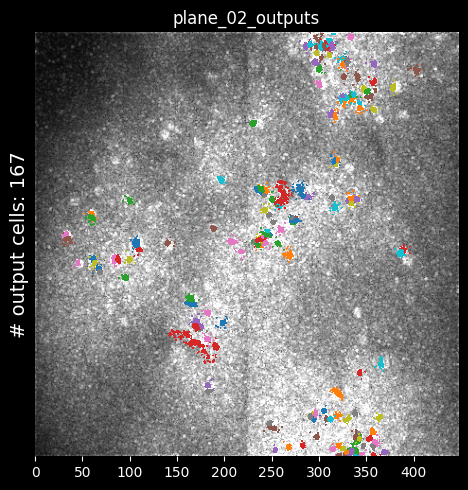

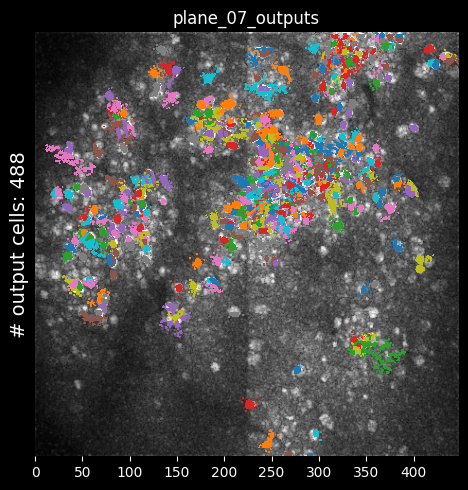

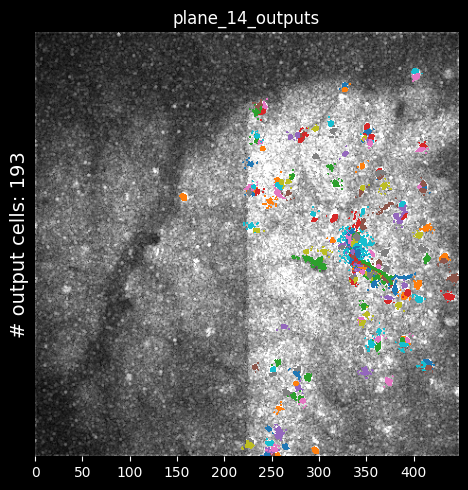

In [4]:
%matplotlib inline
files = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract", 'h5', 2)
for i,f in enumerate(files):
    outputs = load_extract_outputs_h5(f)
    plot_output_masks(output=outputs, title=Path(f).stem)
    plt.show()

## Second parameter set

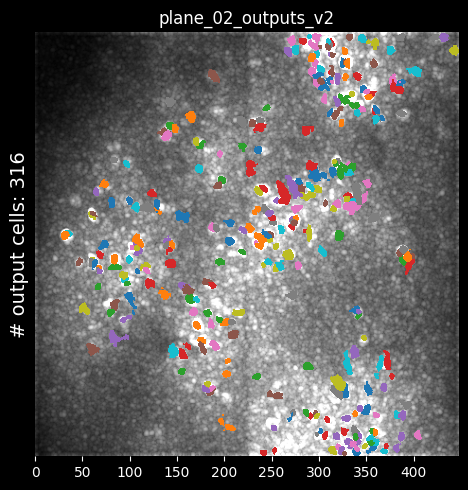

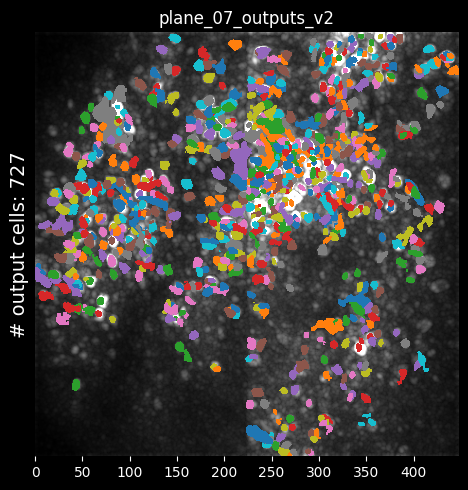

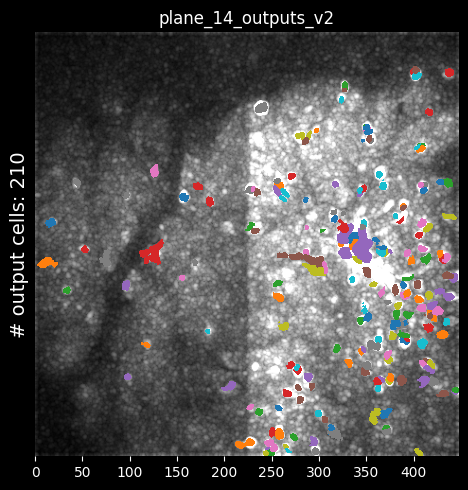

In [5]:
files = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract_v2", 'h5', 2)
for f in files:
    outputs = load_extract_outputs_h5(f)
    plot_output_masks(output=outputs, title=Path(f).stem)
    plt.show()

## Comparison with Suite2p

In [6]:
files_s2p = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\mk301\results", "ops.npy", 3)
files_s2p[:4]

['D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_01_mk301\\plane0\\ops.npy',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_02_mk301\\plane0\\ops.npy',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_03_mk301\\plane0\\ops.npy',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_04_mk301\\plane0\\ops.npy']

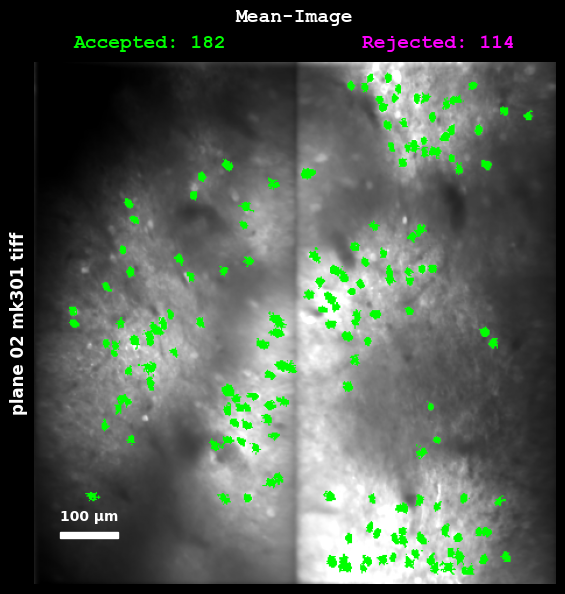

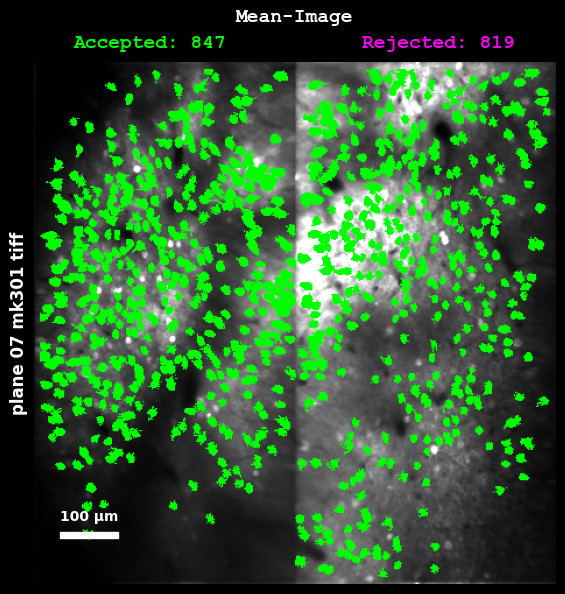

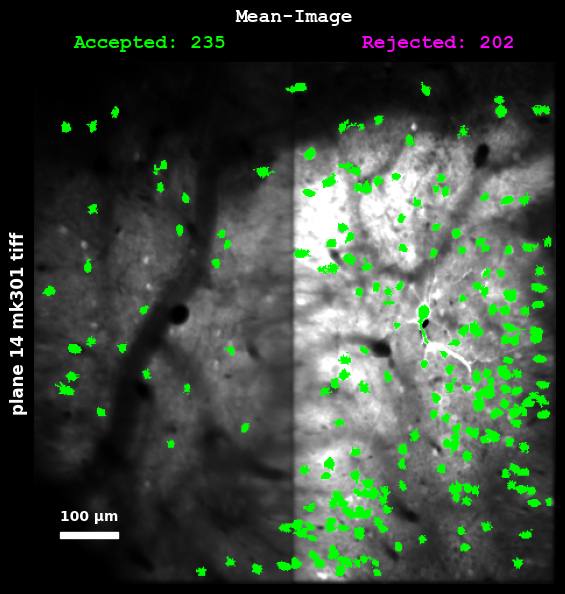

In [7]:
for i, f in enumerate(files_s2p):
    if i in [1, 6, 13]:
        op = lsp.load_ops(f)
        lsp.plot_projection(op, savepath="", add_scalebar=True, proj="meanImg", display_masks=True, accepted_only=True, fig_label=op["tiff_list"][0])

## Compute [Intersection over Union](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

In [8]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

def iou_matrix(masksA, masksB):
    iou = np.zeros((len(masksA), len(masksB)))
    for i in range(len(masksA)):
        for j in range(len(masksB)):
            iou[i, j] = compute_iou(masksA[i], masksB[j])
    return iou

suite2p outputs

In [27]:
files_s2p[1]

'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_02_mk301\\plane0\\ops.npy'

In [28]:
ops = lsp.load_ops(files_s2p[1])
proj = "meanImg"

In [29]:
import suite2p

data = ops[proj]
shape = data.shape

stats_file = Path(ops['save_path']).joinpath('stat.npy')

iscell = np.load(Path(ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)
im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=ops['Ly'], Lx=ops['Lx'], label_id=True)

im[im == 0] = np.nan

extract outputs

In [30]:
files_extract = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract_v2", 'h5', 2)
output = load_extract_outputs_h5(files_extract[0])

info = output['info']
summary_image = info['summary_image']
spatial_weights = output['spatial_weights']
spatial_weights.shape
# plot_output_masks(output=outputs, title=Path(f).stem)

(316, 448, 448)

In [22]:
iou = iou_matrix(spatial_weights, im)

max_iou = iou.max(axis=1)
best_match = iou.argmax(axis=1)
matched = max_iou > 0.3

matched_pairs = [(i, best_match[i]) for i in range(len(im)) if matched[i]]

In [31]:

iscell = np.load(Path(ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)

im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=ops['Ly'], Lx=ops['Lx'], label_id=True)
im[im == 0] = np.nan

# ✅ Only keep accepted cells
im = im[iscell]

[IoU](../docs/_images/IoU.png)

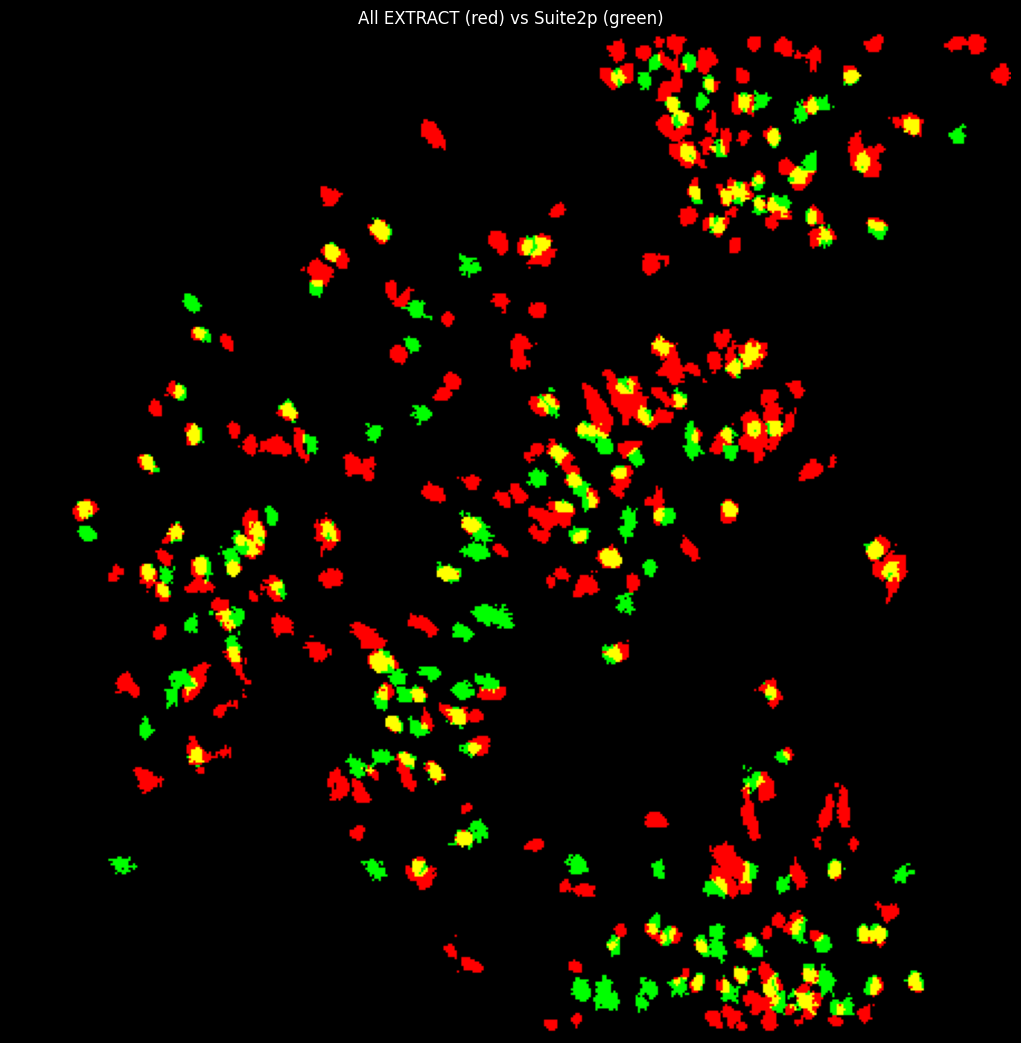

196 EXTRACT cells matched with Suite2p at IoU > 0.3


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

spatial_weights_bin = (spatial_weights > 0).astype(np.uint8)  # EXTRACT
im_bin = (~np.isnan(im)).astype(np.uint8)                     # Suite2p


# Dilation-based soft IoU
def compute_soft_iou(mask1, mask2, dilation_iter=2):
    m1 = binary_dilation(mask1, iterations=dilation_iter)
    m2 = binary_dilation(mask2, iterations=dilation_iter)
    intersection = np.logical_and(m1, m2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

def iou_matrix_dilated(masksA, masksB, dilation_iter=2):
    nA, nB = masksA.shape[0], masksB.shape[0]
    iou = np.zeros((nA, nB))
    for i in range(nA):
        for j in range(nB):
            iou[i, j] = compute_soft_iou(masksA[i], masksB[j], dilation_iter)
    return iou

extract_masks = spatial_weights_bin
suite2p_masks = im
suite2p_masks = (im > 0).astype(np.uint8)

iou = iou_matrix_dilated(extract_masks, suite2p_masks)

extract_all = extract_masks.any(axis=0)
suite2p_all = suite2p_masks.any(axis=0)

overlay = np.zeros((*extract_all.shape, 3))
overlay[..., 0] = extract_all  # Red
overlay[..., 1] = suite2p_all  # Green

plt.imshow(overlay)
plt.title("All EXTRACT (red) vs Suite2p (green)")
plt.axis("off")
plt.show()

matches = np.max(iou, axis=1)
n_matches = np.sum(matches > 0.3)
print(f"{n_matches} EXTRACT cells matched with Suite2p at IoU > 0.3")